**Цель блокнота - построить простую трендовую стратегию Momentum на ETF, которые включают в себя только обыкновенные акции** 

Промежуточные шаги:

1. Выгрузить данные по ценам закрытия с Yahoo Finance на основе списка тикеров из csv-файла

2. Привести цены к нужному виду

3. Построить сетку результатов Momentum-стратегии исходя из разных сроков наблюдения за позициями и удержания

4. Детальнее изучить отдельный портфель

# Загрузка и установка пакетов

In [2]:
#!pip install --force pqr==0.2.8

In [53]:
import numpy as np
import pandas as pd
import yfinance as yf
import re
import matplotlib.pyplot as plt
import pqr
plt.rcParams['figure.figsize'] = (16, 9)

In [49]:
from importlib.metadata import version
version('pqr')

'0.2.8'

pqr - 0.2.8

pandas - 1.3.0

numpy - 1.21.0

matplotlib - 3.4.2

yfinance - 0.1.63

# 1 - Загрузка ценовых данных по ETF

Открываем общий csv-файл со всей информацией

In [33]:
etf_df = pd.read_csv('etf_table.csv', index_col=0)
etf_df

,Symbol,Name,Asset Class,Assets
0,SPY,SPDR S&P 500 ETF Trust,Equity,424609000000
1,IVV,iShares Core S&P 500 ETF,Equity,321394000000
2,VTI,Vanguard Total Stock Market ETF,Equity,288248000000
3,VOO,Vanguard S&P 500 ETF,Equity,273279000000
4,QQQ,Invesco QQQ Trust,Equity,207695000000
...,...,...,...,...
2540,PSCQ,Pacer Swan SOS Conservative (October) ETF,Equity,2622100
2541,PSFO,Pacer Swan SOS Flex (October) ETF,Equity,5356000
2542,PSMO,Pacer Swan SOS Moderate (October) ETF,Equity,12119200
2543,BLKC,Invesco Alerian Galaxy Blockchain Users and De...,Equity,6078800


Создаем отдельную таблицу с фондами, которые инвестируют только в акции

In [34]:
equity_etf = etf_df[etf_df['Asset Class'] == 'Equity']
equity_etf

,Symbol,Name,Asset Class,Assets
0,SPY,SPDR S&P 500 ETF Trust,Equity,424609000000
1,IVV,iShares Core S&P 500 ETF,Equity,321394000000
2,VTI,Vanguard Total Stock Market ETF,Equity,288248000000
3,VOO,Vanguard S&P 500 ETF,Equity,273279000000
4,QQQ,Invesco QQQ Trust,Equity,207695000000
...,...,...,...,...
2540,PSCQ,Pacer Swan SOS Conservative (October) ETF,Equity,2622100
2541,PSFO,Pacer Swan SOS Flex (October) ETF,Equity,5356000
2542,PSMO,Pacer Swan SOS Moderate (October) ETF,Equity,12119200
2543,BLKC,Invesco Alerian Galaxy Blockchain Users and De...,Equity,6078800


Сохраним тикеры в список, который мы будем использовать для запроса в Yahoo Finance

In [35]:
etf_list = equity_etf['Symbol'].to_list()

Выгружаем цены по списку ETF за максимально доступный период с шагом в 1 торговый день:

In [36]:
etf_data = yf.download(tickers = etf_list, period = 'max', interval = '1d', group_by = 'ticker')

[*********************100%***********************]  1804 of 1804 completed


In [38]:
etf_data

MJUS                                               BOAT  \
            Open   High    Low  Close Adj Close   Volume       Open   
Date                                                                  
1993-01-29   NaN    NaN    NaN    NaN       NaN      NaN        NaN   
1993-02-01   NaN    NaN    NaN    NaN       NaN      NaN        NaN   
1993-02-02   NaN    NaN    NaN    NaN       NaN      NaN        NaN   
1993-02-03   NaN    NaN    NaN    NaN       NaN      NaN        NaN   
1993-02-04   NaN    NaN    NaN    NaN       NaN      NaN        NaN   
...          ...    ...    ...    ...       ...      ...        ...   
2021-11-09  7.49  7.490  7.200  7.400     7.400  14300.0  27.670000   
2021-11-10  7.21  7.280  7.029  7.086     7.086   7100.0  27.629999   
2021-11-11  7.14  7.445  7.140  7.400     7.400   7100.0  27.299999   
2021-11-12  7.50  7.820  7.490  7.730     7.730  10600.0  27.379999   
2021-11-15  7.90  8.150  7.680  7.710     7.710  21000.0  27.510000   

                                             ...       JHMH             \
                 High        Low      Close  ...        Low      Close   
Date                                         ...                         
1993-01-29        NaN        NaN        NaN  ...        NaN        NaN   
1993-02-01        NaN        NaN        NaN  ...        NaN        NaN   
1993-02-02        NaN        NaN        NaN  ...        NaN        NaN   
1993-02-03        NaN        NaN        NaN  ...        NaN        NaN   
1993-02-04        NaN        NaN        NaN  ...        NaN        NaN   
...               ...        ...        ...  ...        ...        ...   
2021-11-09  27.719999  27.309999  27.610001  ...  50.036999  50.036999   
2021-11-10  27.629999  26.990999  27.059999  ...  49.990002  50.090000   
2021-11-11  27.600000  27.298000  27.500000  ...  49.985001  49.985001   
2021-11-12  27.533001  27.360001  27.533001  ...  50.130001  50.174000   
2021-11-15  27.510000  26.990000  27.049999  ...  49.838001  49.838001   

                                    SPTM                                   \
            Adj Close  Volume       Open       High        Low      Close   
Date                                                                        
1993-01-29        NaN     NaN        NaN        NaN        NaN        NaN   
1993-02-01        NaN     NaN        NaN        NaN        NaN        NaN   
1993-02-02        NaN     NaN        NaN        NaN        NaN        NaN   
1993-02-03        NaN     NaN        NaN        NaN        NaN        NaN   
1993-02-04        NaN     NaN        NaN        NaN        NaN        NaN   
...               ...     ...        ...        ...        ...        ...   
2021-11-09  50.036999   900.0  57.930000  57.950001  57.570000  57.720001   
2021-11-10  50.090000  2800.0  57.490002  57.720001  57.080002  57.290001   
2021-11-11  49.985001   100.0  57.500000  57.500000  57.299999  57.330002   
2021-11-12  50.174000   300.0  57.450001  57.770000  57.360001  57.730000   
2021-11-15  49.838001  1200.0  57.889999  57.889999  57.599998  57.720001   

                                 
            Adj Close    Volume  
Date                             
1993-01-29        NaN       NaN  
1993-02-01        NaN       NaN  
1993-02-02        NaN       NaN  
1993-02-03        NaN       NaN  
1993-02-04        NaN       NaN  
...               ...       ...  
2021-11-09  57.720001  236000.0  
2021-11-10  57.290001  247000.0  
2021-11-11  57.330002  197600.0  
2021-11-12  57.730000  187600.0  
2021-11-15  57.720001  216600.0  

[7253 rows x 10824 columns]

# 2 - Обработка данных

Приведем данные к месячному виду. Значением месяца будет значение последнего дня в этом месяце

In [39]:
etf_data_montly = etf_data.resample('M').last()
etf_data_montly

MJUS                                               BOAT  \
             Open   High    Low  Close Adj Close   Volume       Open   
Date                                                                   
1993-01-31    NaN    NaN    NaN    NaN       NaN      NaN        NaN   
1993-02-28    NaN    NaN    NaN    NaN       NaN      NaN        NaN   
1993-03-31    NaN    NaN    NaN    NaN       NaN      NaN        NaN   
1993-04-30    NaN    NaN    NaN    NaN       NaN      NaN        NaN   
1993-05-31    NaN    NaN    NaN    NaN       NaN      NaN        NaN   
...           ...    ...    ...    ...       ...      ...        ...   
2021-07-31  8.910  8.950  8.750  8.816     8.816   4600.0        NaN   
2021-08-31  8.170  8.170  8.050  8.104     8.104   7800.0  28.100000   
2021-09-30  7.750  7.750  7.560  7.708     7.708  15300.0  28.059999   
2021-10-31  6.829  6.838  6.695  6.750     6.750   7100.0  27.590000   
2021-11-30  7.900  8.150  7.680  7.710     7.710  21000.0  27.510000   

                                         ...       JHMH                        \
                 High    Low      Close  ...        Low      Close  Adj Close   
Date                                     ...                                    
1993-01-31        NaN    NaN        NaN  ...        NaN        NaN        NaN   
1993-02-28        NaN    NaN        NaN  ...        NaN        NaN        NaN   
1993-03-31        NaN    NaN        NaN  ...        NaN        NaN        NaN   
1993-04-30        NaN    NaN        NaN  ...        NaN        NaN        NaN   
1993-05-31        NaN    NaN        NaN  ...        NaN        NaN        NaN   
...               ...    ...        ...  ...        ...        ...        ...   
2021-07-31        NaN    NaN        NaN  ...  49.790001  49.833000  49.833000   
2021-08-31  28.219999  28.00  28.118000  ...  50.750000  50.870998  50.870998   
2021-09-30  28.260000  27.91  28.135000  ...  48.223000  48.223000  48.223000   
2021-10-31  27.590000  27.35  27.530001  ...  49.590000  50.090000  50.090000   
2021-11-30  27.510000  26.99  27.049999  ...  49.838001  49.838001  49.838001   

                         SPTM                                              \
            Volume       Open       High        Low      Close  Adj Close   
Date                                                                        
1993-01-31     NaN        NaN        NaN        NaN        NaN        NaN   
1993-02-28     NaN        NaN        NaN        NaN        NaN        NaN   
1993-03-31     NaN        NaN        NaN        NaN        NaN        NaN   
1993-04-30     NaN        NaN        NaN        NaN        NaN        NaN   
1993-05-31     NaN        NaN        NaN        NaN        NaN        NaN   
...            ...        ...        ...        ...        ...        ...   
2021-07-31   500.0  54.029999  54.320000  54.029999  54.090000  54.090000   
2021-08-31   600.0  55.770000  55.810001  55.599998  55.680000  55.680000   
2021-09-30  2700.0  53.840000  53.910000  52.959999  52.990002  52.990002   
2021-10-31  2700.0  56.209999  56.630001  56.209999  56.580002  56.580002   
2021-11-30  1200.0  57.889999  57.889999  57.599998  57.720001  57.720001   

                      
              Volume  
Date                  
1993-01-31       NaN  
1993-02-28       NaN  
1993-03-31       NaN  
1993-04-30       NaN  
1993-05-31       NaN  
...              ...  
2021-07-31  168900.0  
2021-08-31  312700.0  
2021-09-30  538300.0  
2021-10-31  796600.0  
2021-11-30  216600.0  

[347 rows x 10824 columns]

Оставим данные только по Adjusted Close для каждого фонда:

In [40]:
etf_montly_adj_price = etf_data_montly.xs('Adj Close', level = 1, axis = 1)
etf_montly_adj_price

,MJUS,BOAT,QRMI,QVML,CNRG,FLGR,BFIT,SPVM,SPHQ,PGAL,...,EIDO,SKF,SBM,XCEM,TMAT,RXI,DBEM,DRIP,JHMH,SPTM
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-31,8.816,NaN,NaN,25.556772,98.773048,26.895000,30.000000,48.740002,49.889999,10.78,...,20.090000,9.78,10.16,32.618000,22.879999,169.440002,27.600000,9.23,49.833000,54.090000
2021-08-31,8.104,28.068521,24.395679,26.370567,98.204071,27.252001,30.604000,50.180000,50.860001,11.41,...,21.260000,9.17,10.11,33.779999,23.398001,168.639999,27.930000,8.79,50.870998,55.680000
2021-09-30,7.708,28.135000,23.747576,25.152000,93.949997,25.718000,28.719999,48.299999,48.549999,11.03,...,21.690001,9.61,10.76,32.164001,21.864000,164.970001,27.180000,6.02,48.223000,52.990002


Да, технически Yahoo выдает данные с 1993г, но тогда торговалось слишком мало фондов. Разумнее начать тестировать стратегии с 2010г:

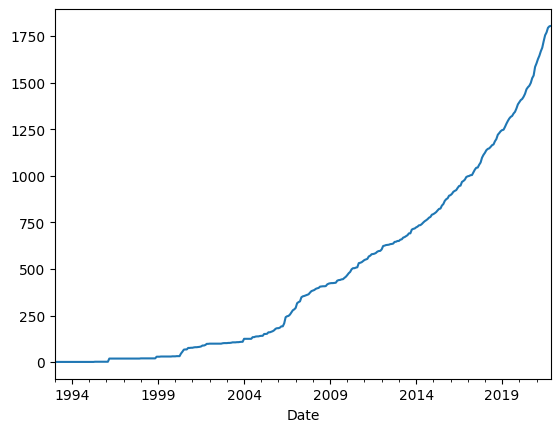

In [43]:
etf_montly_adj_price.count(axis=1).plot()
plt.show()

Создадим второй файл со стартовой датой январь 2010г:

In [45]:
etf_prices = etf_montly_adj_price[204:]
etf_prices = etf_prices.replace(0, np.nan)
etf_prices

,MJUS,BOAT,QRMI,QVML,CNRG,FLGR,BFIT,SPVM,SPHQ,PGAL,...,EIDO,SKF,SBM,XCEM,TMAT,RXI,DBEM,DRIP,JHMH,SPTM
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.756053,NaN,...,NaN,780.304749,NaN,NaN,NaN,36.207016,NaN,NaN,NaN,10.682706
2010-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.002937,NaN,...,NaN,723.687561,NaN,NaN,NaN,37.033199,NaN,NaN,NaN,11.077261
2010-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.735348,NaN,...,NaN,608.239197,49.393082,NaN,NaN,39.946117,NaN,NaN,NaN,11.796785
2010-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.048069,NaN,...,NaN,574.711609,48.006195,NaN,NaN,41.130024,NaN,NaN,NaN,11.999502
2010-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.653060,NaN,...,18.872618,666.754089,52.493771,NaN,NaN,37.706062,NaN,NaN,NaN,11.046734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-31,8.816,NaN,NaN,25.556772,98.773048,26.895000,30.000000,48.740002,49.889999,10.78,...,20.090000,9.780000,10.160000,32.618000,22.879999,169.440002,27.600000,9.23,49.833000,54.090000
2021-08-31,8.104,28.068521,24.395679,26.370567,98.204071,27.252001,30.604000,50.180000,50.860001,11.41,...,21.260000,9.170000,10.110000,33.779999,23.398001,168.639999,27.930000,8.79,50.870998,55.680000
2021-09-30,7.708,28.135000,23.747576,25.152000,93.949997,25.718000,28.719999,48.299999,48.549999,11.03,...,21.690001,9.610000,10.760000,32.164001,21.864000,164.970001,27.180000,6.02,48.223000,52.990002


# 3 - Построение стратегии Cross-Sectional Momentum

Данные готовы и можно приступать к построению первой стратегии. Сперва **ответим для себя на следующие вопросы:**

1) По логике моментума, мы должны отбирать ETF с наибольшим ростом цены за предыдущий период. Какой период для принятия решений взять? 1/2/3/12 месяцев?

2) После покупки мы удерживаем позиции минимум 1 период. Но может делать такие частые ребалансировки излишне?

3) В академических исследованиях иногда говорится о целесообразности выставления лага между периодом наблюдения и покупкой. Если он нужен, то какой период достаточен?

4) Логика портфельного тестирования предполагает разделение доступной выборки на определенное количество портфелей по квантилям. Какой квантиль применить в нашем случае?

5) По какому показателю принимать решение об эффективности стратегии?

**Универсальный ответ на все пять вопросов - нужно перебирать как можно большее число параметров для поиска устойчивости.** Для 1-3 пунктов мы используем параметры перебора периодов. Для 4-5 пунктов, потребуется запуск нескольких бэктестов с таргетированием разных метрик и параметрами квантилей.

Зададим параметры перебора и выберем среднюю доходность стратегии как целевую метрику:

In [46]:
target_mean_return = lambda r: pqr.mean_return(r).value

formation_params = [
    (1, 0, 1),
    (1, 1, 1),
    (3, 0, 3),
    (3, 1, 3),
    (6, 0, 6),
    (6, 1, 6),
    (12, 0, 12),
    (12, 1, 12),
]

lambda r - лямбда функция для выполнения простых расчетов. В данном случае, поиск средней доходнности портфеля;

pqr.mean_return - среднегодовая доходность портфеля за весь период;

В params первая цифра в () означает период наблюдения, вторая - лаг и третья - период ожидания.

**Теперь поработаем над дизайном самой стратегии:**

1) Первые 4 переменные это таблица с ценами ETF, таблица с фактором для принятия решений (для моментума это тоже цены ETF), параметры перебора и целевая метрика, которая будет отражена в таблице.

2) "approach" принимает только два значения - "dynamic" и "static". Поскольку мы хотим отбирать ETF исходя из динамики цен к предыдущему периоду, применяем метод dynamic. Если наш фактор не требует нахождения динамики к предыдущему периоду, то используем static. Например, это мультипликаторы P/E или P/BV для построения стратегии Value.

3) "better" также принимает всего два значения - "more" и "less". Если мы выберем more, то в портфель победителей попадут ETF с наибольшим ростом цены, в портфель p2 ETF из следующего квантиля по динамике цен. И так по убывающей до портфеля losers. Если мы выберем less, то все будет наоборот. Выбирайте метод исходя из экономического смысла.

4) mask используется для фильтрации акций по какому-либо признаку. В данном примере мы не используем фильтры.

5) quantiles определяет, сколько портфелей будет построено из исходной выборки. Мы выбрали 5 квантилей. Соответственно, каждый будет содержать в себе по 20% доступных для покупки ETF на каждый период.

**Построим группу стратегий с разными параметрами моментума через pqr.grid_search:**

In [51]:
momentum_mean_return = pqr.grid_search(stock_prices=etf_prices, factor_data=etf_prices, params=formation_params,
                                       target_metric=target_mean_return, approach='dynamic', better='more',
                                       mask=None, quantiles=5)

momentum_mean_return

,winners,p2,p3,p4,losers
"(1, 0, 1)",0.082609,0.122681,0.116378,0.100059,0.036861
"(1, 1, 1)",0.077682,0.118558,0.118115,0.098207,0.042881
"(3, 0, 3)",0.085108,0.121239,0.122028,0.119258,0.044511
"(3, 1, 3)",0.075635,0.122423,0.128769,0.123350,0.061720
"(6, 0, 6)",0.115875,0.122935,0.130986,0.130842,0.002256
"(6, 1, 6)",0.108726,0.117606,0.121115,0.116851,0.003445
"(12, 0, 12)",0.122925,0.115142,0.108995,0.085852,-0.002635
"(12, 1, 12)",0.141765,0.116032,0.107469,0.082721,-0.019244


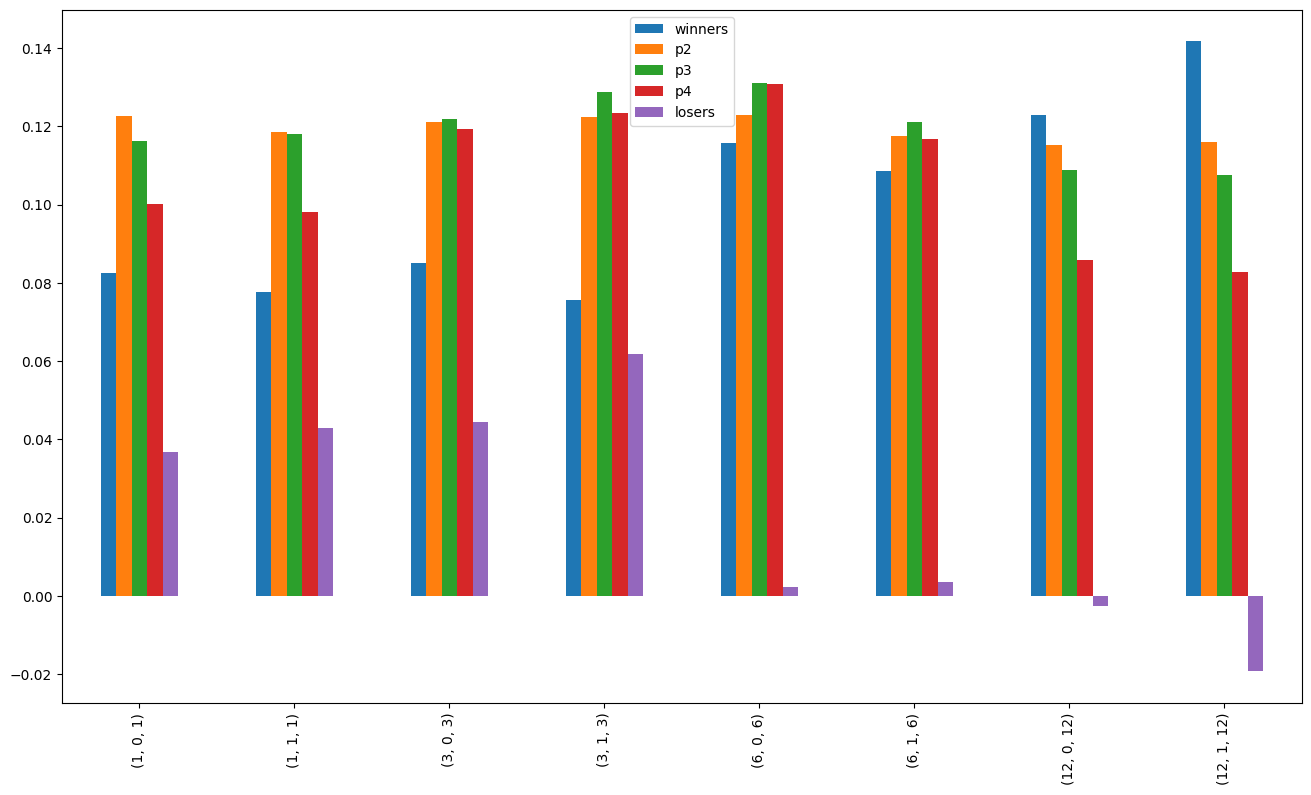

In [55]:
momentum_mean_return.plot.bar()
plt.show()

Теперь, когда мы видим общую картину, можем детальнее изучить метрики и динамику интересующей нас стратегии. Наилучшие результаты показала вариация портфеля 12-1-12. Ее мы и рассмотрим. Зададим фактор (!не стратегию) momentum с нужными параметрами через pqr.Factor:

In [56]:
momentum = pqr.Factor(etf_prices).look_back(12, 'dynamic').lag(1).hold(12)

В скобках Factor() находится DataFrame с фактором, на основе которого мы создаем фактор;

look_back(12, 'dynamic') - период наблюдения 12 и динамичный расчет фактора на основе изменения к периоду t-12;

lag(1) - используем лаг 1 месяц между наблюдением и формированием портфеля;

hold(12) - удержание позиций 12 месяцев.

In [57]:
momentum_portfolios = pqr.fit_quantile_factor_model(stock_prices=etf_prices, factor=momentum, weighting_factor=None, 
                                                    better='more', fee_rate=0, quantiles=5, add_wml=True)
momentum_portfolios

[Portfolio('winners'),
 Portfolio('p2'),
 Portfolio('p3'),
 Portfolio('p4'),
 Portfolio('losers'),
 Portfolio('wml')]

stock_prices - DataFrame с ценами для расчета доходности портфеля;

factor - фактор для принятия решений о покупках и продажах;

weighting_factor - способов задания весов. При =None и по умолчанию задаются равные веса. При задании других весов (например, по mcap) используйте подготовленный фактор без отрицательных значений. Пример в блокноте value.ipynb;

better - в портфелей победителей будут отобраны акции с наибольшим значением фактора при =more и наоборот при =less;

fee_rate - комиссия за сделки в % для каждой сделки. По умолчанию =0. Например, комиссия 0.05% = 0.0005

quantiles - количество квантилей (портфелей) на которую будет разделена вся выборка в каждом периоде исходя из factor. 5 квантилей = 5 портфелей по 20% акций;

add_wml - включение арбитражного (Winners Minus Losers) портфеля из покупки победителей и шорта по проигравшим.

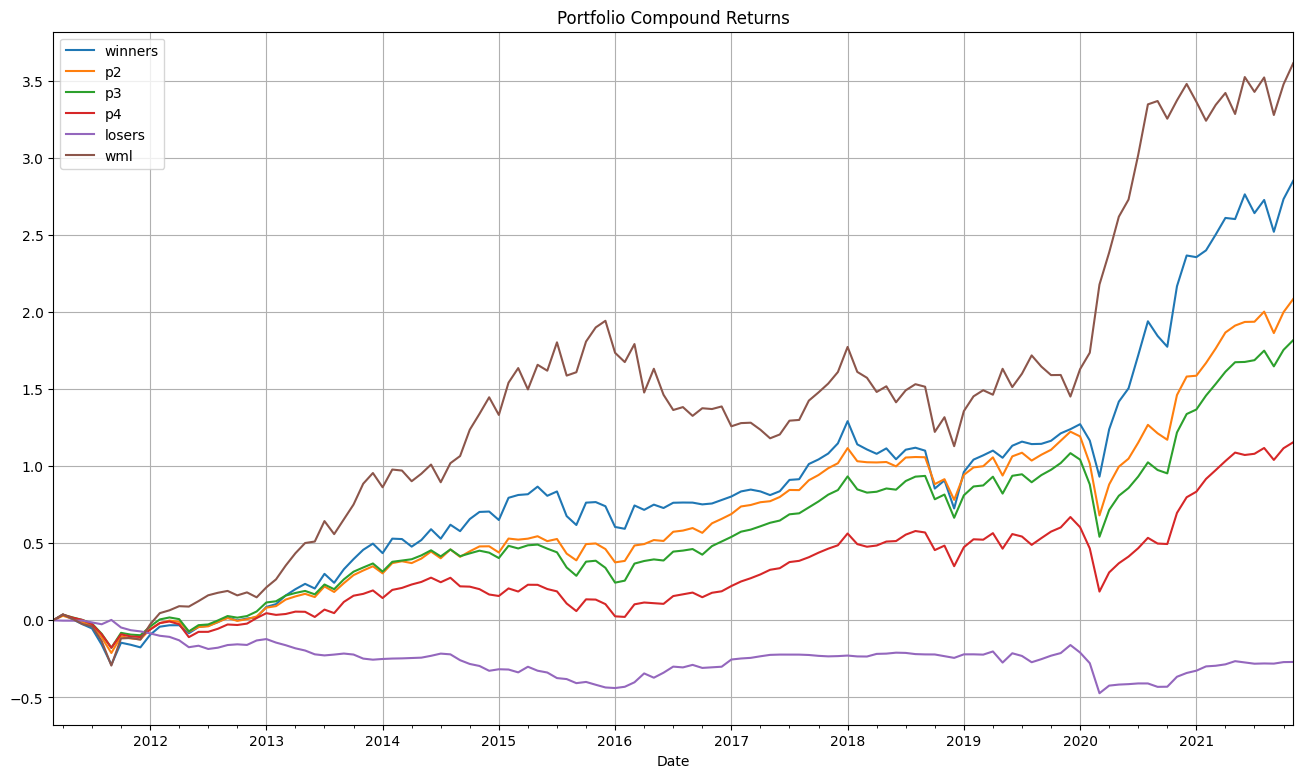

In [59]:
pqr.plot_compound_returns(momentum_portfolios)
plt.show()

**Мы видим почти линейную связь между результатами по накопленной доходности и квантилем моментума. Чем выше предыдущая доходность фонда, тем лучше результат портфеля в будущем. Также за счет отрицательной доходности фондов-ауйтсайдеров, арбитражная Winners-minus-Losers (WML) стратегия дает наибольшую доходность**

# 4 - Аналитика по стратегии и сравнение с бенчмарком

Бенчмарком для нас будет равновзвешенный индекс из всех фондов в выборке. Доходность бенчмарка отражает результат, который мы бы получили если в равных долях покупали все фонды, доступные на каждый период

In [60]:
equal_benchmark = pqr.Benchmark().from_stock_universe(etf_prices)

,winners,p2,p3,p4,losers,wml
"Total Return, %",285.23,208.5,181.81,115.56,-27.0,361.52
"CAGR, %",13.37,11.05,10.12,7.41,-2.89,15.29
"Volatility, %",17.87,14.68,14.58,14.78,13.7,19.1
"Win Rate, %",63.57,67.44,68.99,60.47,48.84,63.57
"Maximum Drawdown, %",-31.33,-24.42,-26.02,-28.96,-47.43,-31.99
"VaR, %",-25.16,-22.09,-24.39,-24.27,-17.5,-23.56
"Expected Tail Loss, %",-37.17,-32.56,-33.21,-34.29,-32.9,-36.65
Rachev Ratio,1.23,1.07,1.01,0.95,0.87,1.2
Calmar Ratio,0.43,0.45,0.39,0.26,-0.06,0.48
Sharpe Ratio,0.79,0.79,0.74,0.56,-0.14,0.84


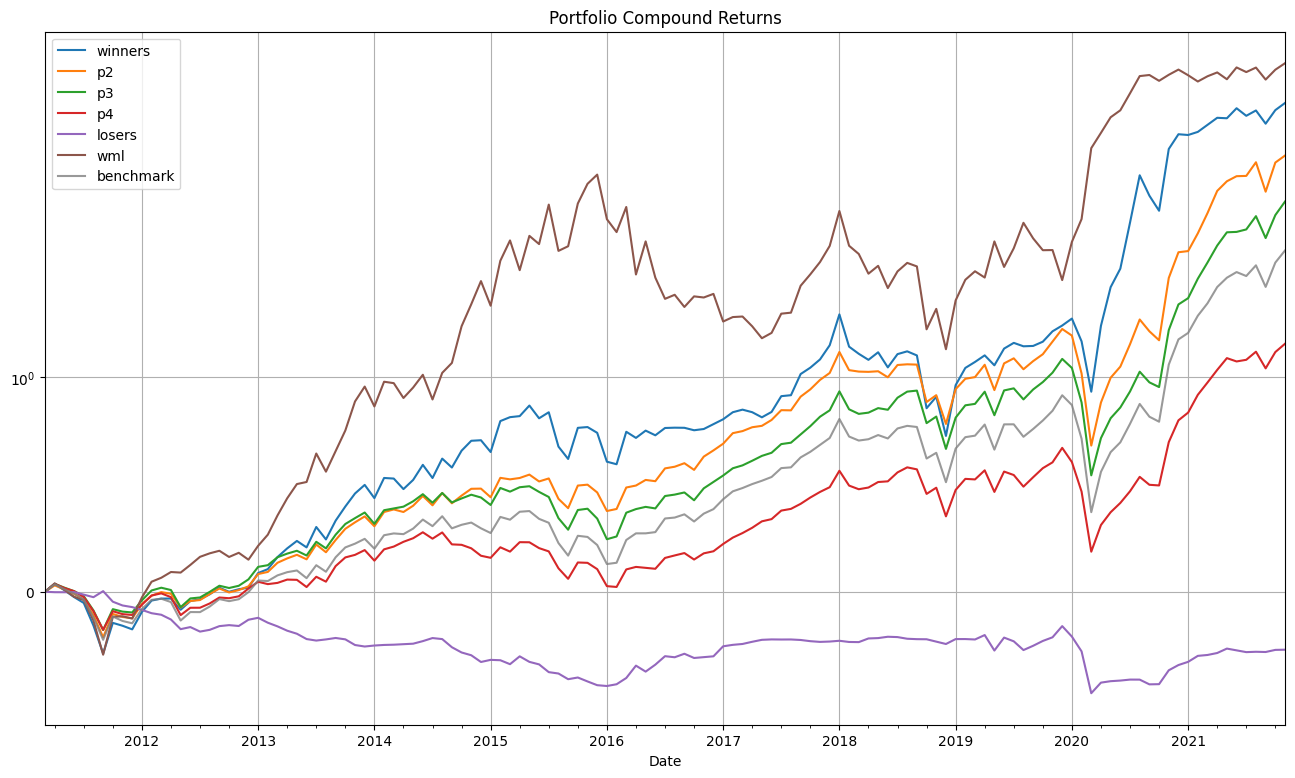

In [61]:
pqr.summary_tear_sheet(portfolios=momentum_portfolios, benchmark=equal_benchmark)